<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<p>
<h1>Algorítmica Avanzada</h1>
<h2>Práctica 3 - Dynamic Programming </h2>
</center>
</p>
</div>

En esta sesión de programación dinámica veremos únicamente un algoritmo de procesamiento de imágenes. En este notebook se incluyen muchos conceptos que puede que os suenen extraños a día de hoy, sobretodo si no se ha visto tratamiento de imágenes. Independientemente, la única parte del algoritmo que se os pide impementar es aquella que contiene de forma explícita la programación dinámica, así que solo nos hace falta ver la imagen como una matriz de valores y de esta forma podremos trabajar con ella sin demasiado problema.

## 0 Conceptos esenciales

1. __Imágen__: Aunque existen diversas representaciones de una imagen a nivel informático, nosotros trabajaremos con la representación RGB, en la que una imagen de $m \times n$ pixeles se representa con una matriz de $m \times n \times 3$ (Una capa para Red, otra para Green y otra para Blue)
<img src="./img/rgb.png" width=50%>

2. __Gradiente de una imágen__: El gradiente de una imagen es, intuitivamente el valor puntual de la derivada de la imagen en un punto concreto. De forma mas sencilla, el gradiente de una imagen muestra cuanto de diferente es el valor de un pixel respecto a los elementos adyacentes. En una zona en la que el gradiente sea bajo se tratará de una zona homogenea, y una zona de gradiente alto suele indicar un borde.
<img src="./img/grad.png" width=50%>

## 1 Seam Carving
El algoritmo Seam Carving es un algoritmo que nos permite redimensionar imágenes teniendo en cuenta el contenido de la misma.

![Seam Carving](./img/seamcarving.jpg )

El método consite en lo siguiente, dada una imagen cualquiera:
![](./img/sc0.png)
1. Calcular el gradiente horizontal de la imágen en valor absoluto
![](./img/sc1.png)
2. Cómputo de todos los posibles caminos mínimos
![](./img/sc2.png)
3. Obtener el camino mínimo
![](./img/sc3.png)
4. Eliminar el camino mínimo
  

En cas de no tenir els packages:

```
import sys
!{sys.executable} -m pip install numpy matplotlib scipy scikit-image
```

In [1]:
#matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from skimage import color, data, restoration
from seam_carving_util import rgb2gray, norm, top3, del_path, min_at, mark_path

### 1.1 Caminos mínimos

Para simplificar el ejercicio lo máximo posible los apartados 1 y 4 ya están implementados, en el 2 tendremos que crear una matriz del mismo tamaño de la imagen utilizando la siguiente formulación:

Sean $I$ la matriz con los gradientes de la imagen original y $D$ la imagen generada utilizando Dynamic Programming:

$D_{i,j} = I_{i,j}+\min\Big[D_{i-1, j-1},\quad D_{i-1, j},\quad D_{i-1,j+1}\Big]$

Intuitivamente, calculamos $D_{i,j}$ como la suma de $I_{i,j}$ y el valor mínimo de los tres elementos superiores.

0. Carga la imagen original


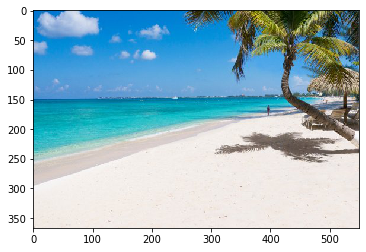

1. Calcula el gradiente horizontal de la imagen


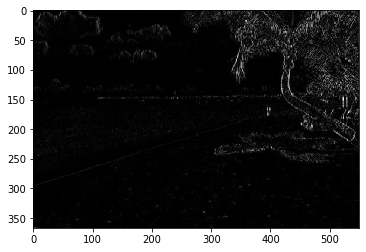

In [2]:
%matplotlib inline
## Carga la imagen en memoria
print("0. Carga la imagen original")
im = plt.imread('img/beach.jpg') / 255.
plt.imshow(im)
plt.show()

## Aplica un filtro de Sobel para calcular el gradiente
print("1. Calcula el gradiente horizontal de la imagen")
dx = nd.sobel(rgb2gray(im), 1)
plt.imshow(np.abs(dx), cmap='gray')
plt.show()

In [3]:
def dynamic_programming(mat):
    """
    Se pueden utilizar las funciones importadas del archivo seam_carving_util.py que son:
    - top3: obtiene los tres elementos superiores (es decir, el valor de los 3 elementos superiores)
            de un punto (píxel) en la matriz
    - min_at: obtiene la posición del elemento mas pequeño de un array
    
    
    Nota: Existeix np.argmin
    
    
    Arguments
    ---------
        mat, np.ndarray
            Two dimensional numpy object
        
    Returns
    -------
        np.ndarray
            Numpy array with the same shape as mat
    """
    
    # Init the DP matrix to an empty
    # ndarray with same hsape as mat
    
    dp_mat = np.empty(mat.shape)
    
    # We loop over all the elements of mat
    # and fill the empty ndarray
    
    for i in range(1, dp_mat.shape[0]):
        for j in range(dp_mat.shape[1]):
            dp_mat[i][j] = mat[i][j] + min(top3(dp_mat, [i, j]))
    
    return dp_mat

### Algoritmo 1

In [4]:
def min_path_find(mat):
    """
    Find the optimal vertical energy seam in a 
    two dimensional numpy array.
    
    Arguments
    ---------
        mat, np.ndarray
            Two dimensional numpy object
        
    Returns
    -------
        list, of tuples
            Minimal energy seam
    """

    n, m = mat.shape
    
    # We init the path with the minimal
    # energy of the last row of the image
    
    pivot = (n-1, np.argmin(mat[n-1]))
    path = [pivot]
    
    # Loop over all the rows above the last one
    # and without including the first.
    
    for i in range(n-1, 0, -1):
        
        # Compute the left and right boundaries
        # of the superior triplet of pixels
        # Like top3 but considering the indices
        
        t_l = pivot[1] - 1 if pivot[1] > 0 else pivot[1]
        t_r = pivot[1] + 1 if pivot[1] < m - 1 else pivot[1]
        
        # Generate the list of inidices and compute the
        # argmin of them in the matrix, update the pivot
        # with the optimal one
        
        indices = list(zip([i-1 for _ in range(t_l, t_r+1)], list(range(t_l, t_r+1))))
        arg_min = np.argmin(mat[i-1][t_l:t_r+1])
        
        pivot = indices[arg_min] 
        path.append(pivot)
    
    return path

### Algoritmo 2

Aquest algoritme és una variant de l'anterior. En aquest cas el pirmer pivot pot trobar-se en qualsevol punt de la frontera de la imatge.
És a dir, les llistes mínimes no només seràn verticals i ascendents, sinó també horitzontals.

A més, s'ofereix un parametre opcional (`rand`) que controla l'estrategia alhora d'escollir el mínim pivot de la frontera.
Si aquest és `True`, es computaran els mínims de cada costat de la frontera i es triarà un de manera aleatoria.

In [5]:
from random import choice

def min_path_find_2(mat, rand=False):
    """
    Find the optimal energy seam in a 
    two dimensional numpy array.
    
    Arguments
    ---------
        mat, np.ndarray
            Two dimensional numpy object
            
        rand, bool (optional)
            If the first pivot pick 
            should be pseudo-random
        
    Returns
    -------
        list, of tuples
            Minimal energy seam
    """

    n, m = mat.shape
    vert = True
    
    # Compute the boundary borders
    
    top = [((0, i), mat[0][i]) for i in range(m)]
    bot = [((n-1, i), mat[n-1][i]) for i in range(m)]
    left = [((i, 0), mat[i][0]) for i in range(n)]
    right = [((i, m-1), mat[i][m-1]) for i in range(n)]
    
    if rand:
        
        # Random step:
        # Maybe the global min of the boundary is not the best
        # so we can compute the min of each border, and pick
        # one randomly
        
        pivot = choice([
                min(top, key=lambda x: x[1]),
                min(bot, key=lambda x: x[1]),
                min(left, key=lambda x: x[1]),
                min(right, key=lambda x: x[1])])[0]
        
    else:
        
        # In general, we will pick the global min
        # point of the whole boundary
        
        bound = top + bot + left + right 
        pivot = min(bound, key=lambda x: x[1])[0]

    path = [pivot]
    
    # Vertical, going down
    
    if pivot[0] == 0:
        for i in range(n-1):
            t_l = pivot[1] - 1 if pivot[1] > 0 else pivot[1]
            t_r = pivot[1] + 1 if pivot[1] < m - 1 else pivot[1]

            indices = list(zip([i+1 for _ in range(t_l, t_r+1)], list(range(t_l, t_r+1))))
            arg_min = np.argmin(mat[i+1, t_l:t_r+1])

            pivot = indices[arg_min] 
            path.append(pivot)
        
    # Vertical, going up    
    
    elif pivot[0] == n-1:
        for i in range(n-1, 0, -1):
            t_l = pivot[1] - 1 if pivot[1] > 0 else pivot[1]
            t_r = pivot[1] + 1 if pivot[1] < m - 1 else pivot[1]

            indices = list(zip([i-1 for _ in range(t_l, t_r+1)], list(range(t_l, t_r+1))))
            arg_min = np.argmin(mat[i-1, t_l:t_r+1])

            pivot = indices[arg_min] 
            path.append(pivot)
            
    # Horizontal, going right    
    
    elif pivot[1] == 0:
        for i in range(m-1):
            t_l = pivot[0] - 1 if pivot[0] > 0 else pivot[0]
            t_r = pivot[0] + 1 if pivot[0] < n - 1 else pivot[0]

            indices = list(zip(list(range(t_l, t_r+1)), [i+1 for _ in range(t_l, t_r+1)]))
            arg_min = np.argmin(mat[t_l:t_r+1, i+1])

            pivot = indices[arg_min] 
            path.append(pivot)
            
        vert = False
        
    # Horizontal, going left    
    
    elif pivot[1] == m-1:
        for i in range(m-1, 0, -1):
            t_l = pivot[0] - 1 if pivot[0] > 0 else pivot[0]
            t_r = pivot[0] + 1 if pivot[0] < n - 1 else pivot[0]

            indices = list(zip(list(range(t_l, t_r+1)), [i-1 for _ in range(t_l, t_r+1)]))
            arg_min = np.argmin(mat[t_l:t_r+1, i-1])

            pivot = indices[arg_min] 
            path.append(pivot)
            
        vert = False
    
    return path, vert

### Tests

Obviament, donat que a l'hore de calcular el primer pivot es fan més operacions, l'algoritme `min_path_find_2` és més costos.

In [6]:
from time import time

mat = dynamic_programming(np.abs(dx))

t1 = time()
p1 = min_path_find(mat)
t1 = time() - t1

t2 = time()
p2, _ = min_path_find_2(mat)
t2 = time() - t2

print(f"min_path_find:   {t1:2.6f} s.")
print(f"min_path_find_2: {t2:2.6f} s.")

min_path_find:   0.001402 s.
min_path_find_2: 0.002696 s.


### Refactor utils

La funció que es donat actualment per a borrar llistes d'una imatge (`del_path`) no pot borrar llistes horitzonals. 
Per tant, he hagut d'adaptar la funció per a poder fer-ho.

A més, també he modificat la funció per a pintar llistes de punts, tal que accepti el color de la llsita a pintar com a parametre opcional (tenint el vermell per defecte).

In [7]:
def del_path_gen(mat, path, vert=True):
    """
    Function to delete both 
    vertical and horizontal paths
    
    Parameter
    ---------
        mat, np.ndarray
        
        path, list
        
        vert, bool (optional)
            If True, the path is vertical,
            False for horizontal
    
    Returns
    -------
        np.ndarray
    """
    
    if vert:
        if len(mat.shape) == 2:
            dim = [mat.shape[0], mat.shape[1]-1]
            ret = np.zeros(dim).astype('float')

            for i in path:
                ret[i[0],:i[1]] = mat[i[0],:i[1]]
                ret[i[0],i[1]:] = mat[i[0],i[1]+1:]

            return ret

        if len(mat.shape) == 3 and mat.shape[2] == 3:
            dim = [mat.shape[0], mat.shape[1]-1, mat.shape[2]]
            ret = np.zeros(dim).astype('float')

            for i in path:
                ret[i[0],:i[1], :] = mat[i[0],:i[1], :]
                ret[i[0],i[1]:, :] = mat[i[0],i[1]+1:, :]

            return ret
    else:
        if len(mat.shape) == 2:
            dim = [mat.shape[0]-1, mat.shape[1]]
            ret = np.zeros(dim).astype('float')

            for i in path:
                ret[:i[0],i[1]] = mat[:i[0],i[1]]
                ret[i[0]:,i[1]] = mat[i[0]+1:,i[1]]

            return ret

        if len(mat.shape) == 3 and mat.shape[2] == 3:
            dim = [mat.shape[0]-1, mat.shape[1], mat.shape[2]]
            ret = np.zeros(dim).astype('float')

            for i in path:
                ret[:i[0],i[1], :] = mat[:i[0],i[1], :]
                ret[i[0]:,i[1], :] = mat[i[0]+1:,i[1], :]

            return ret


def mark_path_c(img, path, color=[1, 0, 0]):
    """
    Function to colorize a given path in an image
    with any RGB color.
    
    Parameters
    ----------
        img, np.ndarray
        
        path, list
        
        color, list (optional, default=[1, 0, 0])
            The color to paint with

    Returns
    -------
        np.ndarray
    """
    
    for i in path:
        img[i] = np.array(color)
    
    return img

2. Calcula la matriz de programación dinámica
3. Busca el camino de mínimo cambio (tres metodos)


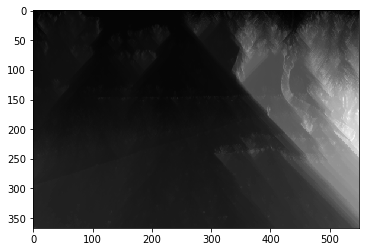

4. Elimina los caminos de la imagen


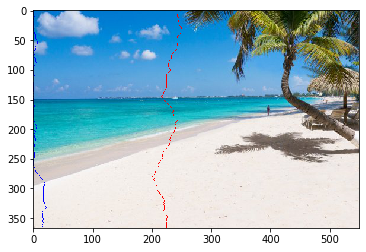

	Rojo:  Algoritmo 1
	Verde: Algoritmo 2
	Azul:  Algoritmo 2, randomizado


In [8]:
# Reset

im = plt.imread('img/beach.jpg') / 255.
dx = nd.sobel(rgb2gray(im), 1)


print("2. Calcula la matriz de programación dinámica")
tmp = dynamic_programming(np.abs(dx))

print("3. Busca el camino de mínimo cambio (tres metodos)")
path1 = min_path_find(tmp)
path2, v1 = min_path_find_2(tmp)
path3, v2 = min_path_find_2(tmp, rand=True)

plt.imshow(tmp, cmap='gray')
plt.show()

print("4. Elimina los caminos de la imagen")

updated = del_path_gen(im, path1) 
updated = del_path_gen(im, path2, vert=v1) 
updated = del_path_gen(im, path3, vert=v2) 

# Muestra el camino eliminado sobre la imágen original

im = mark_path_c(im, path1, color=[1, 0, 0]) # Red
im = mark_path_c(im, path2, color=[0, 1, 0]) # Green
im = mark_path_c(im, path3, color=[0, 0, 1]) # Blue

plt.imshow(im)
plt.show()

print("\tRojo:  Algoritmo 1")
print("\tVerde: Algoritmo 2")
print("\tAzul:  Algoritmo 2, randomizado")

### 1.2 Eliminando zonas concretas de una imagen

Ahora suponed que, en lugar de eliminar el camino mínimo de una imagen queremos eliminar un elemento de la imagen sin que se note. Tomad como ejemplo las siguientes dos imágenes.

![](./img/agbar_a.png)
![](./img/agbar_b.jpg)

Alguna idea de como obtener este resultado?

<IPython.core.display.Javascript object>


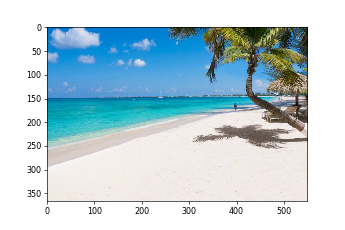

In [10]:
"""
Para que funcionen los siguientes bloques de código, es probable que tengáis que reiniciar el kernel.
Aquí obtenemos las coordenadas de una imagen obteniendo los clicks del usuario sobre esta.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

beach = plt.imread('./img/beach.jpg') / 255.
coords = []

def onclick(event):
    print(event)
    global ix, iy
    ix, iy = event.xdata, event.ydata

    global coords
    coords.append((int(ix), int(iy)))
    
    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords


fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(beach)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

Ahora le asignamos un peso a la imagen equivalente a `-1e+9` en cada uno de los puntos de dentro del cuadrado mínimo

[(222, 123), (255, 157)]


<IPython.core.display.Javascript object>


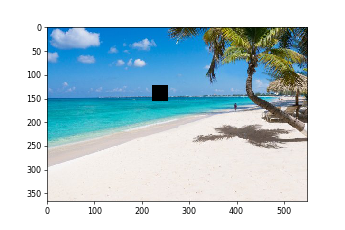

In [11]:
# Erase the white boat in the horizon

if len(coords) != 2:    
    coords = [(222, 123), (255, 157)]

print(coords)
    
def remove_pixels(img, coords):
    img.setflags(write=1)
    
    coords = [(min(coords[0][0], coords[1][0]), min(coords[0][1], coords[1][1])), 
              (max(coords[0][0], coords[1][0]), max(coords[0][1], coords[1][1]))]
    
    if len(img.shape) == 2:
        # Cuadrado a negativo grande. Fuerza a los caminos a pasar por ahí.
        
        img[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0]] = -1e+9
    
    else:
        # Cuadrado a 0. Lo ponemos a negro para el display
        
        img[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0], :] = 0 

    return img

new = remove_pixels(beach, coords)

plt.figure()
plt.imshow(new)

In [12]:
def removePatch(img, coords, algorithm=2, rand=False):
    """
    Use a seam carving DP algortihm 
    to erase a selected zone of an image.
    
    Arguments
    ---------
        img, np.ndarray
            Image to modify
            
        coords, list
            Coordinates of the zone to erase,
            [top-left, bottom-right] corners
        
        algorithm, int (optional=[1,2], default=2)
            Which algorithm to use when finding 
            the optimal seams
                1: Vertical bottom to top seams only
                2: Can begin from anywhere in the corners
        
        rand, bool (optional)
            If the picked algorithm is 2,
            denotes the randomness of the first pivot
    
    Returns
    -------
        np.ndarray
            New image with the zone erased
    """
    
    # Compute the gradient (without the abs value)
    # and the energy matrix of the image with
    # the obscure rectangle
    
    dx = nd.sobel(rgb2gray(img), 1)
    img_mat = remove_pixels(dx, coords)
    mat = dynamic_programming(img_mat)
    
    # The list length is the base length of
    # the rectangle defined by coords
    
    dist = abs(coords[0][1] - coords[1][1])
    
    # We will generate the list of seams
    # to erase
    
    for i in range(dist):
        if algorithm == 1:
            actual = min_path_find(mat)
            mat = del_path_gen(mat, actual)
            img = del_path_gen(img, actual)
            continue
        
        actual, vert = min_path_find_2(mat, rand=rand)
        mat = del_path_gen(mat, actual, vert=vert)
        img = del_path_gen(img, actual, vert=vert)
    
    return img

<IPython.core.display.Javascript object>


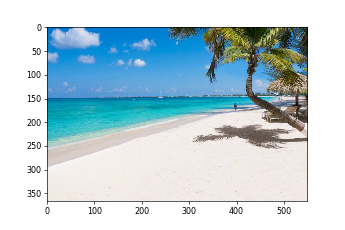

<IPython.core.display.Javascript object>


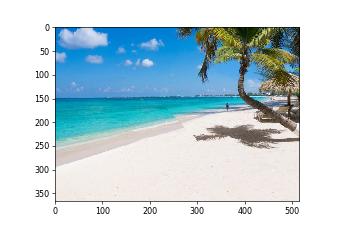

<IPython.core.display.Javascript object>


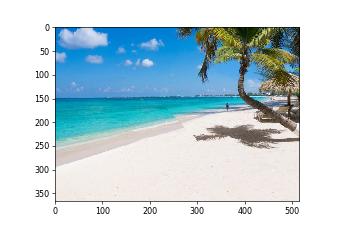

<IPython.core.display.Javascript object>


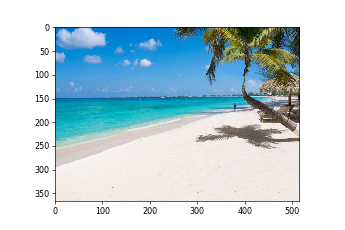

In [13]:
# Original image

img = plt.imread('./img/beach.jpg') / 255.
plt.figure("Original")
plt.imshow(img)
plt.show()

# Algorithm 1: min_path_find

alg1 = removePatch(img, coords, algorithm=1)
plt.figure("Algorithm 1: min_path_find")
plt.imshow(alg1)
plt.show()

# Algorithm 2: min_path_find_2

alg2 = removePatch(img, coords, algorithm=2, rand=False)
plt.figure("Algorithm 2: min_path_find_2")
plt.imshow(alg2)
plt.show()

# Algorithm 2: min_path_find_2, randomized

alg2 = removePatch(img, coords, algorithm=2, rand=True)
plt.figure("Algorithm 2: min_path_find_2, randomized")
plt.imshow(alg2)
plt.show()

<div class="alert alert-info">
<center>
  <h1>Entrega</h1>
</center>
<p>
La entrega de esta práctica se podrá realizar en el campus virtual hasta el día <b>8 de Diciembre a las 23:55</b>. En la tarea que se habilitará en el campus deberéis colgar <b>únicamente este notebook</b> con el nombre:
</p>
<p>
```
[grupo]_[apellido]_[nombre]_3-PD.ipynb
```

</p>
<p>
    Por ejemplo, para un alumno llamado <i>Nombre Genérico</i> perteneciente al <i>grupo Z</i> el nombre del archivo debería ser:
</p>
<p>
```
Z_Generico_Nombre_3-PD.ipynb
```

Y <b>NO</b>:
<ul>
<li>Z00_Generico_Nombre_3-PD.zip</li>
    
<li>ZX_Generico_Nombre_3-PD.ipynb</li>

<li>Lab2_Generico_Nombre_3-PD.rar</li>

<li>3-PD.ipynb</li>
<li> ... literalmente cualquier otra cosa que no sea el nombre que sí hay que ponerle </li>
</ul>
</p>
<p>


Es fundamental que el código esté bién comentado y con un análisis de complejidad exhaustivo del algoritmo. La importancia de poner nombre correcto al archivo debería ser directamente proporcional a lo contentos que queráis que los profesores de prácticas corrijan.<b> No adherirse al formato en el nombre del archivo así como entregar otro tipo de archivo o varios archivos, conllevará a la no corrección de vuestra práctica.</b>
</p>
</div>